In [1]:
# Cell 1: Safe optional installs (NO restart / NO SIGKILL)
import sys, subprocess, importlib.util

def pip_install(pkg):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

# Install only if missing
if importlib.util.find_spec("scikit_posthocs") is None:
    pip_install("scikit-posthocs")

print("✅ Environment ready (no kernel restart)")


✅ Environment ready (no kernel restart)


In [2]:
# Cell 2: Imports (run AFTER restart)
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import wilcoxon, friedmanchisquare
import scikit_posthocs as sp

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
print("Torch:", torch.__version__)


Device: cuda
Torch: 2.6.0+cu124


In [3]:
# Cell 2: Load Dataset and Setup
# ============================================================================

DATA_DIR = "/kaggle/input/saad-3/Microscopic Image Dataset of Plant-Parasitic Nematodes"
base_ds = datasets.ImageFolder(DATA_DIR)
y_all = np.array(base_ds.targets)
n = len(base_ds)
num_classes = len(base_ds.classes)

print(f"Total samples: {n}, Classes: {num_classes}")


Total samples: 1016, Classes: 11


In [4]:
#Cell 3: Define Train:Test Split Ratios (Same as Task 2)
# ============================================================================

# Multiple train:test ratios for comprehensive evaluation
split_ratios = [
    {"train": 0.6, "test": 0.4, "name": "60:40"},
    {"train": 0.7, "test": 0.3, "name": "70:30"},
    {"train": 0.8, "test": 0.2, "name": "80:20"},
]

print("Split ratios:", [r["name"] for r in split_ratios])


Split ratios: ['60:40', '70:30', '80:20']


In [5]:
# Cell 4: SimCLR Model Definition
# ============================================================================

class TwoCropsTransform:
    def __init__(self, base_transform):
        self.base_transform = base_transform
    def __call__(self, x):
        return self.base_transform(x), self.base_transform(x)

class SimCLR(nn.Module):
    def __init__(self, base_encoder, out_dim=128, proj_hidden=512):
        super().__init__()
        self.encoder = base_encoder
        num_ftrs = self.encoder.fc.in_features
        self.encoder.fc = nn.Identity()
        self.proj = nn.Sequential(
            nn.Linear(num_ftrs, proj_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(proj_hidden, out_dim)
        )
    def forward(self, x):
        h = self.encoder(x)
        z = self.proj(h)
        return F.normalize(z, dim=1)

def nt_xent_loss(z_i, z_j, temperature=0.5):
    N = z_i.size(0)
    z = torch.cat([z_i, z_j], dim=0)
    sim = torch.mm(z, z.t()) / temperature
    mask = torch.eye(2*N, device=z.device, dtype=torch.bool)
    sim = sim.masked_fill(mask, -1e9)
    targets = torch.arange(2*N, device=z.device)
    targets = (targets + N) % (2*N)
    return F.cross_entropy(sim, targets)

In [6]:
#Cell 5: Augmentation Configurations for Ablations
# ============================================================================

def get_simclr_transform(config_name="full"):
    """
    Returns different augmentation configurations for ablation study.
    
    Configs:
    - full: All augmentations (baseline)
    - no_color: Remove ColorJitter
    - no_blur: Remove GaussianBlur
    - no_grayscale: Remove RandomGrayscale
    - minimal: Only crop + flip
    """
    base_augs = [
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
    ]
    
    if config_name == "full":
        augs = base_augs + [
            transforms.RandomRotation(20),
            transforms.RandomApply([transforms.ColorJitter(0.4,0.4,0.4,0.1)], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.GaussianBlur(kernel_size=9),
        ]
    elif config_name == "no_color":
        augs = base_augs + [
            transforms.RandomRotation(20),
            transforms.RandomGrayscale(p=0.2),
            transforms.GaussianBlur(kernel_size=9),
        ]
    elif config_name == "no_blur":
        augs = base_augs + [
            transforms.RandomRotation(20),
            transforms.RandomApply([transforms.ColorJitter(0.4,0.4,0.4,0.1)], p=0.8),
            transforms.RandomGrayscale(p=0.2),
        ]
    elif config_name == "no_grayscale":
        augs = base_augs + [
            transforms.RandomRotation(20),
            transforms.RandomApply([transforms.ColorJitter(0.4,0.4,0.4,0.1)], p=0.8),
            transforms.GaussianBlur(kernel_size=9),
        ]
    elif config_name == "minimal":
        augs = base_augs
    else:
        raise ValueError(f"Unknown config: {config_name}")
    
    augs += [
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]
    
    return transforms.Compose(augs)

In [7]:
# Cell 6: Training Function for SimCLR
# ============================================================================

def train_simclr(train_loader, epochs=30, lr=3e-4, temperature=0.5, 
                 proj_hidden=512, out_dim=128, batch_size=64):
    """
    Train SimCLR model and return trained encoder.
    """
    resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    ssl_model = SimCLR(resnet50, out_dim=out_dim, proj_hidden=proj_hidden).to(device)
    optimizer = optim.Adam(ssl_model.parameters(), lr=lr, weight_decay=1e-4)
    
    loss_hist = []
    
    for epoch in range(epochs):
        ssl_model.train()
        total = 0.0
        for (xi, xj), _ in train_loader:
            xi, xj = xi.to(device), xj.to(device)
            zi = ssl_model(xi)
            zj = ssl_model(xj)
            loss = nt_xent_loss(zi, zj, temperature=temperature)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total += loss.item()
        
        avg_loss = total / len(train_loader)
        loss_hist.append(avg_loss)
        
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"  Epoch {epoch+1}/{epochs} loss={avg_loss:.4f}")
    
    # Return frozen encoder
    for p in ssl_model.encoder.parameters():
        p.requires_grad = False
    ssl_model.encoder.eval()
    
    return ssl_model.encoder, loss_hist

In [8]:
# Cell 7: Feature Extraction Function
# ============================================================================

def extract_features(encoder, loader):
    """Extract frozen features from encoder."""
    encoder.eval()
    feats, labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            f = encoder(x).cpu()
            feats.append(f)
            labels.append(y)
    return torch.cat(feats).numpy(), torch.cat(labels).numpy()


In [9]:
# Cell 8: Evaluation Functions
# ============================================================================

def eval_linear_probe(X_train, y_train, X_test, y_test):
    """Evaluate linear probe (logistic regression)."""
    clf = make_pipeline(
        StandardScaler(),
        LogisticRegression(max_iter=5000, solver='saga', random_state=42)
    )
    
    t0 = time.time()
    clf.fit(X_train, y_train)
    train_time = time.time() - t0
    
    t0 = time.time()
    y_pred = clf.predict(X_test)
    test_time = time.time() - t0
    
    acc = accuracy_score(y_test, y_pred)
    
    return {
        'accuracy': acc,
        'train_time': train_time,
        'test_time': test_time,
        'model': clf
    }

def eval_knn(X_train, y_train, X_test, y_test, k=5):
    """Evaluate k-NN classifier."""
    clf = make_pipeline(
        StandardScaler(),
        KNeighborsClassifier(n_neighbors=k)
    )
    clf.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    return acc

def eval_label_efficiency(X_train, y_train, X_test, y_test, ratios=[0.01, 0.05, 0.10, 0.25, 0.50]):
    """Evaluate performance with different amounts of labeled data."""
    results = {}
    rng = np.random.default_rng(42)
    classes = np.unique(y_train)
    
    for r in ratios:
        X_small, y_small = [], []
        for c in classes:
            idx_c = np.where(y_train == c)[0]
            m = max(1, int(len(idx_c) * r))
            chosen = rng.choice(idx_c, m, replace=False)
            X_small.append(X_train[chosen])
            y_small.append(y_train[chosen])
        
        X_small = np.vstack(X_small)
        y_small = np.hstack(y_small)
        
        clf = make_pipeline(
            StandardScaler(),
            LogisticRegression(max_iter=5000, solver='saga', random_state=42)
        )
        clf.fit(X_small, y_small)
        acc = clf.score(X_test, y_test)
        results[r] = acc
    
    return results

In [10]:
# Cell 9: Ablation Study Configuration
# ============================================================================

ablation_configs = [
    {
        "name": "Baseline (Full)",
        "aug_config": "full",
        "epochs": 30,
        "batch_size": 64,
        "lr": 3e-4,
        "temperature": 0.5,
        "proj_hidden": 512,
        "out_dim": 128,
        "description": "Full augmentation pipeline"
    },
    {
        "name": "No Color Jitter",
        "aug_config": "no_color",
        "epochs": 30,
        "batch_size": 64,
        "lr": 3e-4,
        "temperature": 0.5,
        "proj_hidden": 512,
        "out_dim": 128,
        "description": "Remove ColorJitter augmentation"
    },
    {
        "name": "No Gaussian Blur",
        "aug_config": "no_blur",
        "epochs": 30,
        "batch_size": 64,
        "lr": 3e-4,
        "temperature": 0.5,
        "proj_hidden": 512,
        "out_dim": 128,
        "description": "Remove GaussianBlur augmentation"
    },
    {
        "name": "Minimal Augmentation",
        "aug_config": "minimal",
        "epochs": 30,
        "batch_size": 64,
        "lr": 3e-4,
        "temperature": 0.5,
        "proj_hidden": 512,
        "out_dim": 128,
        "description": "Only Crop + Flip"
    },
    {
        "name": "Small Batch",
        "aug_config": "full",
        "epochs": 30,
        "batch_size": 32,
        "lr": 3e-4,
        "temperature": 0.5,
        "proj_hidden": 512,
        "out_dim": 128,
        "description": "Batch size 32 instead of 64"
    },
    {
        "name": "Shallow Projection",
        "aug_config": "full",
        "epochs": 30,
        "batch_size": 64,
        "lr": 3e-4,
        "temperature": 0.5,
        "proj_hidden": 256,
        "out_dim": 128,
        "description": "Smaller projection head (256 hidden)"
    },
    {
        "name": "Higher Temperature",
        "aug_config": "full",
        "epochs": 30,
        "batch_size": 64,
        "lr": 3e-4,
        "temperature": 0.7,
        "proj_hidden": 512,
        "out_dim": 128,
        "description": "Temperature = 0.7 instead of 0.5"
    },
]

print(f"Total ablation configurations: {len(ablation_configs)}")
for i, cfg in enumerate(ablation_configs):
    print(f"{i+1}. {cfg['name']}: {cfg['description']}")


Total ablation configurations: 7
1. Baseline (Full): Full augmentation pipeline
2. No Color Jitter: Remove ColorJitter augmentation
3. No Gaussian Blur: Remove GaussianBlur augmentation
4. Minimal Augmentation: Only Crop + Flip
5. Small Batch: Batch size 32 instead of 64
6. Shallow Projection: Smaller projection head (256 hidden)
7. Higher Temperature: Temperature = 0.7 instead of 0.5


In [11]:
# --- DEBUG: force all ablation epochs to run fast ---
DEBUG_EPOCHS = 1   # set to 2 if you want

for cfg in ablation_configs:
    cfg["epochs"] = DEBUG_EPOCHS
print("All ablation epochs set to:", DEBUG_EPOCHS)


All ablation epochs set to: 1


In [12]:
# Cell 10: Run Complete Ablation Study Across All Splits (SAFE VERSION)
# ============================================================================

print("\n" + "="*80)
print("RUNNING COMPLETE ABLATION STUDY")
print("="*80)

import os
all_results = []

SAVE_PATH = "/kaggle/working/ablation_results_simclr.csv"

eval_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

for split_idx, split_cfg in enumerate(split_ratios):
    print(f"\n{'='*80}")
    print(f"SPLIT {split_idx+1}/{len(split_ratios)}: {split_cfg['name']}")
    print(f"{'='*80}")

    sss = StratifiedShuffleSplit(
        n_splits=1,
        test_size=split_cfg['test'],
        random_state=42
    )
    train_idx, test_idx = next(sss.split(np.zeros(n), y_all))
    train_idx, test_idx = np.array(train_idx), np.array(test_idx)

    print(f"Train samples: {len(train_idx)}, Test samples: {len(test_idx)}")

    probe_ds = datasets.ImageFolder(DATA_DIR, transform=eval_tf)
    train_probe = Subset(probe_ds, train_idx)
    test_probe = Subset(probe_ds, test_idx)

    train_probe_loader = DataLoader(train_probe, batch_size=64, shuffle=False, num_workers=0)
    test_probe_loader  = DataLoader(test_probe, batch_size=64, shuffle=False, num_workers=0)

    for abl_idx, abl_cfg in enumerate(ablation_configs):
        print(f"\n{'-'*80}")
        print(f"Ablation {abl_idx+1}/{len(ablation_configs)}: {abl_cfg['name']}")
        print(f"Description: {abl_cfg['description']}")
        print(f"{'-'*80}")

        simclr_transform = get_simclr_transform(abl_cfg['aug_config'])
        ssl_ds = datasets.ImageFolder(DATA_DIR, transform=TwoCropsTransform(simclr_transform))
        train_ssl = Subset(ssl_ds, train_idx)

        train_ssl_loader = DataLoader(
            train_ssl,
            batch_size=abl_cfg['batch_size'],
            shuffle=True,
            num_workers=0,
            drop_last=True
        )

        print("Training SimCLR...")
        start = time.time()
        encoder, loss_hist = train_simclr(
            train_ssl_loader,
            epochs=abl_cfg['epochs'],
            lr=abl_cfg['lr'],
            temperature=abl_cfg['temperature'],
            proj_hidden=abl_cfg['proj_hidden'],
            out_dim=abl_cfg['out_dim']
        )
        ssl_time = time.time() - start
        print(f"SSL training completed in {ssl_time:.2f}s")

        print("Extracting features...")
        X_train, y_train = extract_features(encoder, train_probe_loader)
        X_test,  y_test  = extract_features(encoder, test_probe_loader)

        print("Evaluating linear probe...")
        linear_results = eval_linear_probe(X_train, y_train, X_test, y_test)

        print("Evaluating k-NN (k=5)...")
        knn_acc = eval_knn(X_train, y_train, X_test, y_test, k=5)

        print("Evaluating label efficiency...")
        label_eff = eval_label_efficiency(X_train, y_train, X_test, y_test)

        result = {
            "split_name": split_cfg["name"],
            "ablation_name": abl_cfg["name"],
            "linear_probe_acc": linear_results["accuracy"],
            "knn5_acc": knn_acc,
            "label_eff_1pct": label_eff[0.01],
            "label_eff_5pct": label_eff[0.05],
            "label_eff_10pct": label_eff[0.10],
            "label_eff_25pct": label_eff[0.25],
            "label_eff_50pct": label_eff[0.50],
            "ssl_train_time": ssl_time,
            "final_ssl_loss": loss_hist[-1],
        }

        all_results.append(result)

        # ✅ CRITICAL: SAVE AFTER EVERY EXPERIMENT
        results_df = pd.DataFrame(all_results)
        results_df.to_csv(SAVE_PATH, index=False)
        print(f"✅ Checkpoint saved → {SAVE_PATH}")

        del encoder, ssl_ds, train_ssl, train_ssl_loader
        torch.cuda.empty_cache()

print("\n" + "="*80)
print("ABLATION STUDY COMPLETED")
print("="*80)
print(f"Total experiments completed: {len(all_results)}")



RUNNING COMPLETE ABLATION STUDY

SPLIT 1/3: 60:40
Train samples: 609, Test samples: 407

--------------------------------------------------------------------------------
Ablation 1/7: Baseline (Full)
Description: Full augmentation pipeline
--------------------------------------------------------------------------------
Training SimCLR...


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 234MB/s]


  Epoch 1/1 loss=4.1256
SSL training completed in 40.71s
Extracting features...
Evaluating linear probe...
Evaluating k-NN (k=5)...
Evaluating label efficiency...
✅ Checkpoint saved → /kaggle/working/ablation_results_simclr.csv

--------------------------------------------------------------------------------
Ablation 2/7: No Color Jitter
Description: Remove ColorJitter augmentation
--------------------------------------------------------------------------------
Training SimCLR...
  Epoch 1/1 loss=4.0503
SSL training completed in 22.48s
Extracting features...
Evaluating linear probe...
Evaluating k-NN (k=5)...
Evaluating label efficiency...
✅ Checkpoint saved → /kaggle/working/ablation_results_simclr.csv

--------------------------------------------------------------------------------
Ablation 3/7: No Gaussian Blur
Description: Remove GaussianBlur augmentation
--------------------------------------------------------------------------------
Training SimCLR...
  Epoch 1/1 loss=4.0985
SSL 

In [13]:
# Cell 11: Consolidated Results Table (SAFE)
# ============================================================================

import os
import pandas as pd

CSV_PATH = "/kaggle/working/ablation_results_simclr.csv"

print("\n" + "="*80)
print("CONSOLIDATED RESULTS TABLE")
print("="*80)

if "results_df" not in globals():
    if os.path.exists(CSV_PATH):
        results_df = pd.read_csv(CSV_PATH)
        print(f"✅ Loaded results from {CSV_PATH}")
    else:
        raise RuntimeError("❌ No saved results found. Run Cell 10 first.")

summary_cols = [
    "split_name",
    "ablation_name",
    "linear_probe_acc",
    "knn5_acc",
    "label_eff_10pct",
    "ssl_train_time",
    "final_ssl_loss"
]

summary_df = results_df[summary_cols].round(4)
print(summary_df.to_string(index=False))



CONSOLIDATED RESULTS TABLE
split_name        ablation_name  linear_probe_acc  knn5_acc  label_eff_10pct  ssl_train_time  final_ssl_loss
     60:40      Baseline (Full)            0.6634    0.5332           0.4201         40.7100          4.1256
     60:40      No Color Jitter            0.6634    0.5233           0.4545         22.4769          4.0503
     60:40     No Gaussian Blur            0.6683    0.5160           0.4079         22.0490          4.0985
     60:40 Minimal Augmentation            0.6781    0.5209           0.3538         17.2409          3.7961
     60:40          Small Batch            0.6609    0.5061           0.3956         29.1272          3.3602
     60:40   Shallow Projection            0.6781    0.5553           0.4300         27.7750          4.2307
     60:40   Higher Temperature            0.7150    0.5504           0.4079         26.6596          4.3322
     70:30      Baseline (Full)            0.6623    0.4951           0.4000         32.9944        

In [14]:
# Cell 12: Create Pivot Tables for Statistical Analysis
# ============================================================================

pivot_linear = results_df.pivot(
    index="split_name",
    columns="ablation_name",
    values="linear_probe_acc"
)

pivot_knn = results_df.pivot(
    index="split_name",
    columns="ablation_name",
    values="knn5_acc"
)

pivot_label_eff = results_df.pivot(
    index="split_name",
    columns="ablation_name",
    values="label_eff_10pct"
)

print("✅ Pivot tables created successfully")


✅ Pivot tables created successfully


In [15]:
# Cell 13: Paired t-tests (Baseline vs Each Ablation)
# ============================================================================

print("\n" + "="*80)
print("PAIRED T-TESTS: Baseline vs Each Ablation")
print("="*80)

baseline_name = "Baseline (Full)"

if baseline_name in pivot_linear.columns:
    baseline_scores = pivot_linear[baseline_name].values
    
    print("\nLinear Probe Accuracy:")
    print("-" * 60)
    
    for col in pivot_linear.columns:
        if col != baseline_name:
            comparison_scores = pivot_linear[col].values
            
            # Paired t-test
            t_stat, p_value = stats.ttest_rel(baseline_scores, comparison_scores)
            
            mean_baseline = np.mean(baseline_scores)
            mean_comparison = np.mean(comparison_scores)
            diff = mean_comparison - mean_baseline
            
            # Effect size (Cohen's d for paired samples)
            std_diff = np.std(baseline_scores - comparison_scores, ddof=1)
            cohens_d = diff / std_diff if std_diff > 0 else 0
            
            sig_marker = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
            
            print(f"\n{baseline_name} vs {col}:")
            print(f"  Baseline mean: {mean_baseline:.4f}")
            print(f"  Comparison mean: {mean_comparison:.4f}")
            print(f"  Difference: {diff:+.4f}")
            print(f"  t-statistic: {t_stat:.4f}")
            print(f"  p-value: {p_value:.4f} {sig_marker}")
            print(f"  Cohen's d: {cohens_d:.4f}")
            
            if p_value < 0.05:
                direction = "better" if diff > 0 else "worse"
                print(f"  → Statistically significant: {col} is {direction} than baseline")
            else:
                print(f"  → No significant difference")



PAIRED T-TESTS: Baseline vs Each Ablation

Linear Probe Accuracy:
------------------------------------------------------------

Baseline (Full) vs Higher Temperature:
  Baseline mean: 0.7033
  Comparison mean: 0.6758
  Difference: -0.0275
  t-statistic: 0.6646
  p-value: 0.5747 ns
  Cohen's d: -0.3837
  → No significant difference

Baseline (Full) vs Minimal Augmentation:
  Baseline mean: 0.7033
  Comparison mean: 0.7012
  Difference: -0.0021
  t-statistic: 0.0666
  p-value: 0.9530 ns
  Cohen's d: -0.0384
  → No significant difference

Baseline (Full) vs No Color Jitter:
  Baseline mean: 0.7033
  Comparison mean: 0.6783
  Difference: -0.0250
  t-statistic: 0.7868
  p-value: 0.5138 ns
  Cohen's d: -0.4543
  → No significant difference

Baseline (Full) vs No Gaussian Blur:
  Baseline mean: 0.7033
  Comparison mean: 0.6979
  Difference: -0.0054
  t-statistic: 0.1466
  p-value: 0.8969 ns
  Cohen's d: -0.0846
  → No significant difference

Baseline (Full) vs Shallow Projection:
  Baseline 

In [16]:
# Cell 14: Friedman Test (Multiple Models Comparison)
# ============================================================================

print("\n" + "="*80)
print("FRIEDMAN TEST: Comparing All Ablations")
print("="*80)

# Friedman test for linear probe accuracy
print("\nLinear Probe Accuracy:")
print("-" * 60)

# Prepare data: each row is a split, each column is an ablation
friedman_data = [pivot_linear[col].values for col in pivot_linear.columns]

try:
    stat, p_value = friedmanchisquare(*friedman_data)
    
    print(f"Friedman chi-square: {stat:.4f}")
    print(f"p-value: {p_value:.4f}")
    
    if p_value < 0.05:
        print("→ Significant differences detected among ablations (p < 0.05)")
        print("\nPerforming Nemenyi post-hoc test...")
        
        # Nemenyi post-hoc test
        nemenyi_result = sp.posthoc_nemenyi_friedman(pivot_linear)
        
        print("\nNemenyi post-hoc p-values:")
        print(nemenyi_result.round(4))
        
        # Identify significantly different pairs
        print("\nSignificant pairwise differences (p < 0.05):")
        sig_pairs = []
        for i in range(len(nemenyi_result.columns)):
            for j in range(i+1, len(nemenyi_result.columns)):
                col_i = nemenyi_result.columns[i]
                col_j = nemenyi_result.columns[j]
                p_val = nemenyi_result.iloc[i, j]
                
                if p_val < 0.05:
                    mean_i = pivot_linear[col_i].mean()
                    mean_j = pivot_linear[col_j].mean()
                    better = col_i if mean_i > mean_j else col_j
                    worse = col_j if mean_i > mean_j else col_i
                    sig_pairs.append((better, worse, p_val))
        
        if sig_pairs:
            for better, worse, p_val in sig_pairs:
                print(f"  {better} > {worse} (p={p_val:.4f})")
        else:
            print("  No pairwise differences significant at p < 0.05")
    else:
        print("→ No significant differences among ablations (p >= 0.05)")

except Exception as e:
    print(f"Error in Friedman test: {e}")



FRIEDMAN TEST: Comparing All Ablations

Linear Probe Accuracy:
------------------------------------------------------------
Friedman chi-square: 8.6545
p-value: 0.1940
→ No significant differences among ablations (p >= 0.05)



EFFECT SIZES (vs Baseline)

             ablation  mean_diff  cohens_d  practical_sig
Minimal Augmentation  -0.002120 -0.038449          False
    No Gaussian Blur  -0.005385 -0.084647          False
     No Color Jitter  -0.025040 -0.454285           True
  Shallow Projection  -0.026142 -0.512290           True
  Higher Temperature  -0.027513 -0.383691           True
         Small Batch  -0.038422 -0.797799           True


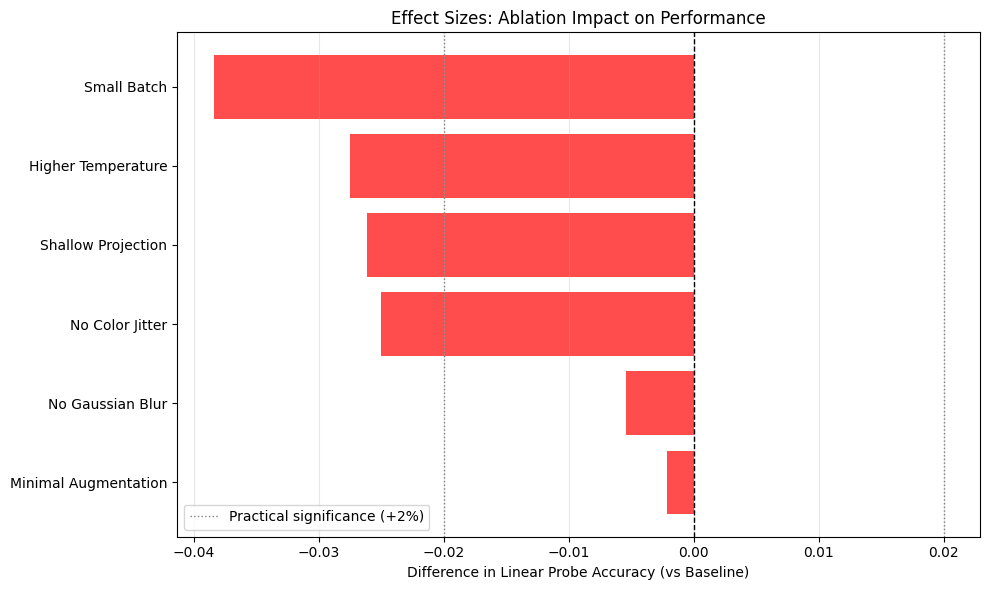

In [17]:
# Cell 15: Effect Sizes - Calculate and Visualize
# ============================================================================

print("\n" + "="*80)
print("EFFECT SIZES (vs Baseline)")
print("="*80)

if baseline_name in pivot_linear.columns:
    baseline_scores = pivot_linear[baseline_name].values
    
    effect_sizes = []
    
    for col in pivot_linear.columns:
        if col != baseline_name:
            comparison_scores = pivot_linear[col].values
            
            # Cohen's d
            diff = np.mean(comparison_scores) - np.mean(baseline_scores)
            std_diff = np.std(baseline_scores - comparison_scores, ddof=1)
            cohens_d = diff / std_diff if std_diff > 0 else 0
            
            # Practical significance threshold
            practical_sig = abs(diff) > 0.02  # 2% accuracy difference
            
            effect_sizes.append({
                'ablation': col,
                'mean_diff': diff,
                'cohens_d': cohens_d,
                'practical_sig': practical_sig
            })
    
    effect_df = pd.DataFrame(effect_sizes)
    effect_df = effect_df.sort_values('mean_diff', ascending=False)
    
    print("\n", effect_df.to_string(index=False))
    
    # Visualize effect sizes
    plt.figure(figsize=(10, 6))
    colors = ['green' if x > 0 else 'red' for x in effect_df['mean_diff']]
    plt.barh(effect_df['ablation'], effect_df['mean_diff'], color=colors, alpha=0.7)
    plt.xlabel('Difference in Linear Probe Accuracy (vs Baseline)')
    plt.title('Effect Sizes: Ablation Impact on Performance')
    plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
    plt.axvline(x=0.02, color='gray', linestyle=':', linewidth=1, label='Practical significance (+2%)')
    plt.axvline(x=-0.02, color='gray', linestyle=':', linewidth=1)
    plt.legend()
    plt.tight_layout()
    plt.grid(axis='x', alpha=0.3)
    plt.show()



VISUALIZATION: Performance Across Splits


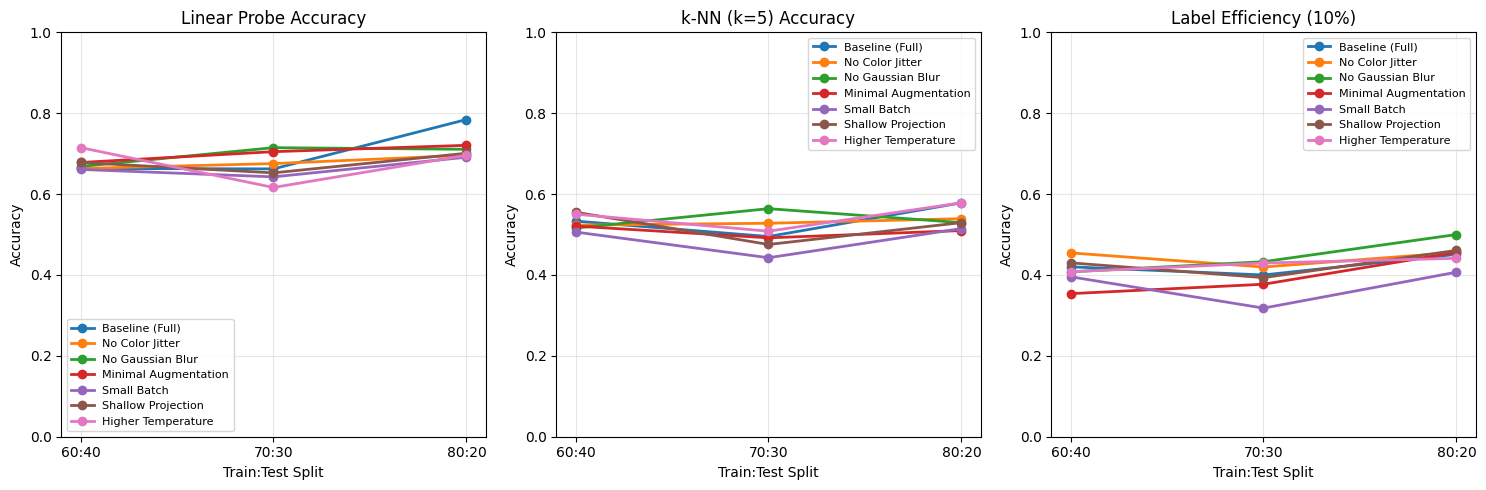

In [18]:
# Cell 16: Visualization - Ablation Comparison Across Splits
# ============================================================================

print("\n" + "="*80)
print("VISUALIZATION: Performance Across Splits")
print("="*80)

# Plot 1: Linear Probe Accuracy by Split
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = [
    ('linear_probe_acc', 'Linear Probe Accuracy'),
    ('knn5_acc', 'k-NN (k=5) Accuracy'),
    ('label_eff_10pct', 'Label Efficiency (10%)')
]

for idx, (metric, title) in enumerate(metrics):
    ax = axes[idx]
    
    for abl_name in results_df['ablation_name'].unique():
        subset = results_df[results_df['ablation_name'] == abl_name]
        ax.plot(subset['split_name'], subset[metric], marker='o', label=abl_name, linewidth=2)
    
    ax.set_xlabel('Train:Test Split')
    ax.set_ylabel('Accuracy')
    ax.set_title(title)
    ax.legend(fontsize=8, loc='best')
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()


VISUALIZATION: Label Efficiency Curves


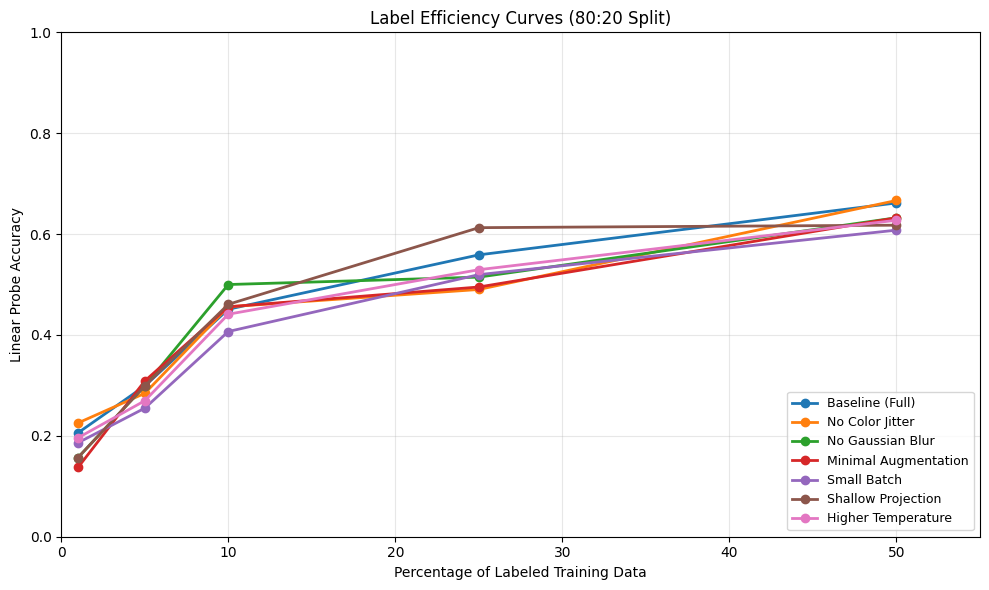

In [19]:
# Cell 17: Visualization - Label Efficiency Curves
# ============================================================================

print("\n" + "="*80)
print("VISUALIZATION: Label Efficiency Curves")
print("="*80)

# For the 80:20 split, plot label efficiency curves
split_80_20 = results_df[results_df['split_name'] == '80:20']

label_ratios = [0.01, 0.05, 0.10, 0.25, 0.50]
label_pcts = [r * 100 for r in label_ratios]

plt.figure(figsize=(10, 6))

for abl_name in split_80_20['ablation_name'].unique():
    row = split_80_20[split_80_20['ablation_name'] == abl_name].iloc[0]
    
    accs = [
        row['label_eff_1pct'],
        row['label_eff_5pct'],
        row['label_eff_10pct'],
        row['label_eff_25pct'],
        row['label_eff_50pct']
    ]
    
    plt.plot(label_pcts, accs, marker='o', label=abl_name, linewidth=2)

plt.xlabel('Percentage of Labeled Training Data')
plt.ylabel('Linear Probe Accuracy')
plt.title('Label Efficiency Curves (80:20 Split)')
plt.legend(fontsize=9, loc='lower right')
plt.grid(True, alpha=0.3)
plt.xlim([0, 55])
plt.ylim([0, 1])
plt.tight_layout()
plt.show()


VISUALIZATION: Results Heatmap


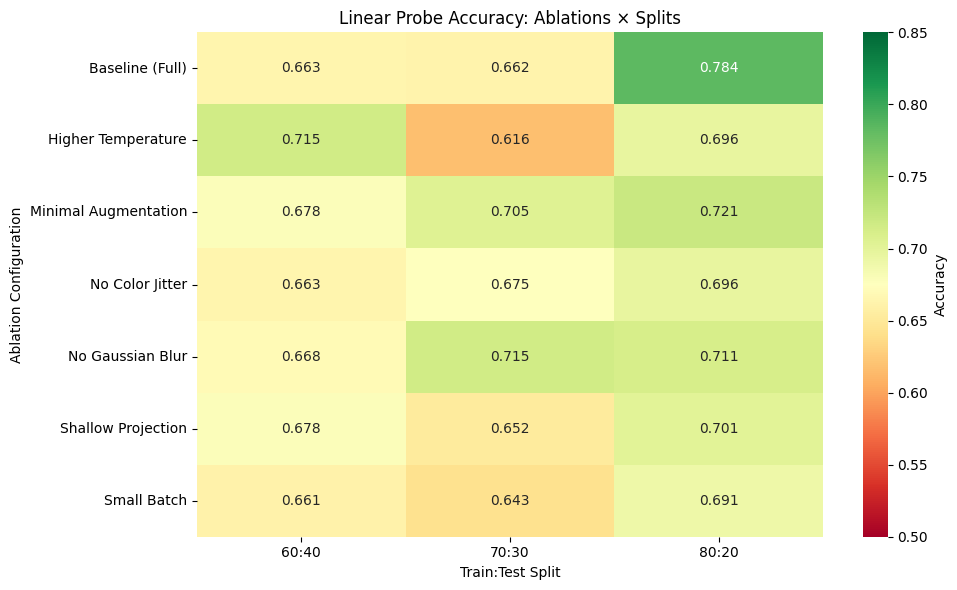

In [20]:
# Cell 18: Visualization - Heatmap of Results
# ============================================================================

print("\n" + "="*80)
print("VISUALIZATION: Results Heatmap")
print("="*80)

# Create heatmap for linear probe accuracy
fig, ax = plt.subplots(figsize=(10, 6))

heatmap_data = results_df.pivot(
    index='ablation_name',
    columns='split_name',
    values='linear_probe_acc'
)

sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlGn', 
            vmin=0.5, vmax=0.85, ax=ax, cbar_kws={'label': 'Accuracy'})
ax.set_title('Linear Probe Accuracy: Ablations × Splits')
ax.set_xlabel('Train:Test Split')
ax.set_ylabel('Ablation Configuration')
plt.tight_layout()
plt.show()


In [21]:
# Cell 19: Summary Statistics Table
# ============================================================================

print("\n" + "="*80)
print("SUMMARY STATISTICS BY ABLATION")
print("="*80)

summary_stats = results_df.groupby('ablation_name').agg({
    'linear_probe_acc': ['mean', 'std', 'min', 'max'],
    'knn5_acc': ['mean', 'std'],
    'label_eff_10pct': ['mean', 'std'],
    'ssl_train_time': ['mean']
}).round(4)

print("\n", summary_stats)

# Rank ablations by mean linear probe accuracy
rankings = results_df.groupby('ablation_name')['linear_probe_acc'].mean().sort_values(ascending=False)

print("\n" + "="*80)
print("ABLATION RANKINGS (by mean Linear Probe Accuracy)")
print("="*80)

for rank, (abl_name, score) in enumerate(rankings.items(), 1):
    print(f"{rank}. {abl_name}: {score:.4f}")



SUMMARY STATISTICS BY ABLATION

                      linear_probe_acc                         knn5_acc  \
                                 mean     std     min     max     mean   
ablation_name                                                            
Baseline (Full)                0.7033  0.0701  0.6623  0.7843   0.5356   
Higher Temperature             0.6758  0.0523  0.6164  0.7150   0.5457   
Minimal Augmentation           0.7012  0.0215  0.6781  0.7206   0.5075   
No Color Jitter                0.6783  0.0165  0.6634  0.6961   0.5301   
No Gaussian Blur               0.6979  0.0257  0.6683  0.7148   0.5364   
Shallow Projection             0.6772  0.0243  0.6525  0.7010   0.5200   
Small Batch                    0.6649  0.0245  0.6426  0.6912   0.4878   

                             label_eff_10pct         ssl_train_time  
                         std            mean     std           mean  
ablation_name                                                        
Baseline (Full)

In [22]:
# Cell 20: Practical vs Statistical Significance Analysis
# ============================================================================

print("\n" + "="*80)
print("PRACTICAL vs STATISTICAL SIGNIFICANCE")
print("="*80)

if baseline_name in pivot_linear.columns:
    baseline_mean = pivot_linear[baseline_name].mean()
    
    print(f"\nBaseline mean accuracy: {baseline_mean:.4f}")
    print("\nAnalyzing each ablation:")
    print("-" * 60)
    
    for col in pivot_linear.columns:
        if col != baseline_name:
            comparison_scores = pivot_linear[col].values
            baseline_scores = pivot_linear[baseline_name].values
            
            # Statistical test
            t_stat, p_value = stats.ttest_rel(baseline_scores, comparison_scores)
            statistically_sig = p_value < 0.05
            
            # Practical significance (2% threshold)
            mean_comparison = comparison_scores.mean()
            diff = mean_comparison - baseline_mean
            practically_sig = abs(diff) > 0.02
            
            print(f"\n{col}:")
            print(f"  Mean accuracy: {mean_comparison:.4f} ({diff:+.4f})")
            print(f"  Statistical significance: {'YES (p={:.4f})'.format(p_value) if statistically_sig else 'NO (p={:.4f})'.format(p_value)}")
            print(f"  Practical significance: {'YES (|diff|={:.4f})'.format(abs(diff)) if practically_sig else 'NO (|diff|={:.4f})'.format(abs(diff))}")
            
            # Interpretation
            if statistically_sig and practically_sig:
                print(f"  → BOTH statistically and practically significant")
            elif statistically_sig and not practically_sig:
                print(f"  → Statistically significant but NOT practically significant")
            elif not statistically_sig and practically_sig:
                print(f"  → Practically significant but NOT statistically significant (may need more samples)")
            else:
                print(f"  → Neither statistically nor practically significant")


PRACTICAL vs STATISTICAL SIGNIFICANCE

Baseline mean accuracy: 0.7033

Analyzing each ablation:
------------------------------------------------------------

Higher Temperature:
  Mean accuracy: 0.6758 (-0.0275)
  Statistical significance: NO (p=0.5747)
  Practical significance: YES (|diff|=0.0275)
  → Practically significant but NOT statistically significant (may need more samples)

Minimal Augmentation:
  Mean accuracy: 0.7012 (-0.0021)
  Statistical significance: NO (p=0.9530)
  Practical significance: NO (|diff|=0.0021)
  → Neither statistically nor practically significant

No Color Jitter:
  Mean accuracy: 0.6783 (-0.0250)
  Statistical significance: NO (p=0.5138)
  Practical significance: YES (|diff|=0.0250)
  → Practically significant but NOT statistically significant (may need more samples)

No Gaussian Blur:
  Mean accuracy: 0.6979 (-0.0054)
  Statistical significance: NO (p=0.8969)
  Practical significance: NO (|diff|=0.0054)
  → Neither statistically nor practically signifi

In [23]:
# Cell 21: Key Findings Summary
# ============================================================================

print("\n" + "="*80)
print("KEY FINDINGS SUMMARY")
print("="*80)

print("\n1. BEST PERFORMING ABLATIONS:")
top_3 = rankings.head(3)
for rank, (abl_name, score) in enumerate(top_3.items(), 1):
    print(f"   {rank}. {abl_name}: {score:.4f}")

print("\n2. WORST PERFORMING ABLATIONS:")
bottom_3 = rankings.tail(3)
for rank, (abl_name, score) in enumerate(bottom_3.items(), 1):
    print(f"   {rank}. {abl_name}: {score:.4f}")

print("\n3. MOST IMPACTFUL ABLATIONS (vs Baseline):")
if baseline_name in pivot_linear.columns:
    baseline_scores = pivot_linear[baseline_name].values
    impacts = []
    
    for col in pivot_linear.columns:
        if col != baseline_name:
            comparison_scores = pivot_linear[col].values
            diff = comparison_scores.mean() - baseline_scores.mean()
            impacts.append((col, diff))
    
    impacts.sort(key=lambda x: abs(x[1]), reverse=True)
    
    for abl_name, diff in impacts[:3]:
        direction = "improved" if diff > 0 else "degraded"
        print(f"   {abl_name}: {direction} by {abs(diff):.4f}")

print("\n4. STATISTICAL SIGNIFICANCE:")
if baseline_name in pivot_linear.columns:
    sig_count = 0
    for col in pivot_linear.columns:
        if col != baseline_name:
            comparison_scores = pivot_linear[col].values
            baseline_scores = pivot_linear[baseline_name].values
            _, p_value = stats.ttest_rel(baseline_scores, comparison_scores)
            if p_value < 0.05:
                sig_count += 1
    
    print(f"   {sig_count} out of {len(pivot_linear.columns)-1} ablations showed")
    print(f"   statistically significant differences from baseline (p < 0.05)")

print("\n5. LABEL EFFICIENCY:")
best_label_eff = results_df.groupby('ablation_name')['label_eff_10pct'].mean().idxmax()
best_label_eff_score = results_df.groupby('ablation_name')['label_eff_10pct'].mean().max()
print(f"   Best label efficiency (10% labels): {best_label_eff}")
print(f"   Score: {best_label_eff_score:.4f}")



KEY FINDINGS SUMMARY

1. BEST PERFORMING ABLATIONS:
   1. Baseline (Full): 0.7033
   2. Minimal Augmentation: 0.7012
   3. No Gaussian Blur: 0.6979

2. WORST PERFORMING ABLATIONS:
   1. Shallow Projection: 0.6772
   2. Higher Temperature: 0.6758
   3. Small Batch: 0.6649

3. MOST IMPACTFUL ABLATIONS (vs Baseline):
   Small Batch: degraded by 0.0384
   Higher Temperature: degraded by 0.0275
   Shallow Projection: degraded by 0.0261

4. STATISTICAL SIGNIFICANCE:
   0 out of 6 ablations showed
   statistically significant differences from baseline (p < 0.05)

5. LABEL EFFICIENCY:
   Best label efficiency (10% labels): No Gaussian Blur
   Score: 0.4469


In [24]:
# Cell 22: Export Final Summary Report
# ============================================================================

print("\n" + "="*80)
print("EXPORTING SUMMARY REPORT")
print("="*80)

# Create comprehensive summary report
report_lines = []

report_lines.append("=" * 80)
report_lines.append("TASK 7: ABLATION STUDY SUMMARY REPORT - SimCLR")
report_lines.append("=" * 80)
report_lines.append("")

report_lines.append("EXPERIMENTAL SETUP:")
report_lines.append(f"  - Total ablation configurations: {len(ablation_configs)}")
report_lines.append(f"  - Train:test split ratios: {[r['name'] for r in split_ratios]}")
report_lines.append(f"  - Total experiments: {len(results_df)}")
report_lines.append("")

report_lines.append("ABLATION CONFIGURATIONS TESTED:")
for i, cfg in enumerate(ablation_configs, 1):
    report_lines.append(f"  {i}. {cfg['name']}: {cfg['description']}")
report_lines.append("")

report_lines.append("STATISTICAL TESTS PERFORMED:")
report_lines.append("  1. Paired t-tests (Baseline vs each ablation)")
report_lines.append("  2. Friedman test (comparing all ablations)")
report_lines.append("  3. Nemenyi post-hoc test (pairwise comparisons)")
report_lines.append("  4. Effect size analysis (Cohen's d)")
report_lines.append("")

report_lines.append("KEY FINDINGS:")
report_lines.append(f"  Best ablation: {rankings.index[0]} (acc: {rankings.iloc[0]:.4f})")
report_lines.append(f"  Baseline: {baseline_name} (acc: {rankings[baseline_name]:.4f})")
report_lines.append(f"  Worst ablation: {rankings.index[-1]} (acc: {rankings.iloc[-1]:.4f})")
report_lines.append("")

# Write to file
with open('ablation_summary_report.txt', 'w') as f:
    f.write('\n'.join(report_lines))

print("Summary report saved to: ablation_summary_report.txt")

# Save statistical test results
stats_results = {
    'paired_t_tests': [],
    'friedman_test': None,
}

if baseline_name in pivot_linear.columns:
    baseline_scores = pivot_linear[baseline_name].values
    
    for col in pivot_linear.columns:
        if col != baseline_name:
            comparison_scores = pivot_linear[col].values
            t_stat, p_value = stats.ttest_rel(baseline_scores, comparison_scores)
            
            stats_results['paired_t_tests'].append({
                'comparison': f"{baseline_name} vs {col}",
                't_statistic': t_stat,
                'p_value': p_value,
                'significant': p_value < 0.05
            })

# Save as JSON
import json
with open('statistical_tests_results.json', 'w') as f:
    json.dump(stats_results, f, indent=2)

print("Statistical test results saved to: statistical_tests_results.json")

print("\n" + "="*80)
print("TASK 7 COMPLETED SUCCESSFULLY")
print("="*80)
print("\nGenerated files:")
print("  1. ablation_results_simclr.csv - Full results table")
print("  2. ablation_summary_report.txt - Summary report")
print("  3. statistical_tests_results.json - Statistical test results")
print("\nAll visualizations displayed above.")


EXPORTING SUMMARY REPORT
Summary report saved to: ablation_summary_report.txt


TypeError: Object of type bool_ is not JSON serializable